In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
 
import matplotlib.pyplot as plt
 
from datetime import datetime
from numpy.fft import fft
from scipy.signal import spectrogram, periodogram
from scipy.stats import median_absolute_deviation, shapiro, skew, kurtosis
from statsmodels.robust import mad
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error

# Load ECG Dataset

In [ ]:
ecg_df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
ecg_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

# Separate labels from features

In [ ]:
y = ecg_df.iloc[:, -1].astype(bool)
X = ecg_df.iloc[:, :-1]

# Distribution of data

In [ ]:
pval = np.mean([shapiro(X[col])[1] for col in X.columns])
normal_const = 0.05
print(f"P-Value obtained during Shapiro-Wilk's normality test {pval}")
if pval > 0.05:
    print('Dataset looks like it was drawn from normal distribution (fails to reject the null hypothesis).')
else:
    print('Dataset does not look Gaussian (rejects the null hypothesis).')

P-Value obtained during Shapiro-Wilk's normality test 1.4387653274983802e-13
Dataset does not look Gaussian (rejects the null hypothesis).


# Split data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# Normalize data

In [ ]:
normalizer = MinMaxScaler()

X_train_scaled = normalizer.fit_transform(X_train)
X_test_scaled = normalizer.transform(X_test)

# Categorize data into normal and anomalous based on labels

In [ ]:
X_train_normal = X_train_scaled[y_train]
X_test_normal = X_test_scaled[y_test]

X_train_anomalous = X_train_scaled[~y_train]
X_test_anomalous = X_test_scaled[~y_test]

# Skewness and Kurtosis

In [ ]:
def skew_and_kurt(X):
  x_skew = pd.Series(skew(X))
  x_kurt = pd.Series(kurtosis(X))
  print(f'Column characterized by the highest skewness {x_skew.max()} is {x_skew.argmax()}')
  print(f'Column characterized by the lowest skewness {x_skew.min()} is {x_skew.argmin()}')
  print(f'Average skewness is {x_skew.mean()}\n')
  print(f'Column characterized by the highest kurtosis {x_kurt.max()} is {x_kurt.argmax()}')
  print(f'Column characterized by the lowest kurtosis {x_kurt.min()} is {x_kurt.argmin()}')
  print(f'Average kurtosis is {x_kurt.mean()}\n')
  skew_cols, kurt_cols = [
    x.sort_values(ascending=False, key=abs).index[:5] for x in [x_skew, x_kurt]
  ]
  X_skew, X_kurt = map(lambda cols: pd.DataFrame(X[:, cols], columns=cols), [skew_cols, kurt_cols])
  return X_skew, X_kurt

In [ ]:
print('- Healthy data')
X_skew, X_kurt = skew_and_kurt(X_train_normal)
print('\n- Unhealthy data')
X_skew_anom, X_kurt_anom = skew_and_kurt(X_train_anomalous)

- Healthy data
Column characterized by the highest skewness 2.2847362037965935 is 26
Column characterized by the lowest skewness -2.458427822906742 is 80
Average skewness is -0.04576331373810708

Column characterized by the highest kurtosis 13.922311271659403 is 86
Column characterized by the lowest kurtosis -0.1783528669605201 is 139
Average kurtosis is 4.721149152305564


- Unhealthy data
Column characterized by the highest skewness 1.7989129516876763 is 135
Column characterized by the lowest skewness -3.725201148809736 is 41
Average skewness is -1.4219204853596292

Column characterized by the highest kurtosis 41.40043521193575 is 59
Column characterized by the lowest kurtosis -0.25831639225337977 is 138
Average kurtosis is 15.578086135925563



In [ ]:
def histplot(X_normal, X_anom, title):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
  labels = ['Healthy', 'Anomalous']
  data = [X_normal, X_anom]
  for i, X in enumerate(data):
    sns.histplot(X, kde=True, ax=ax[i])
    ax[i].set_title(labels[i])
    ax[i].legend([f'Sample {col}' for col in X.columns])
    ax[i].set_xlabel(title)
  plt.suptitle(f'Samples characterized by highest absolute {title}')
  plt.show()

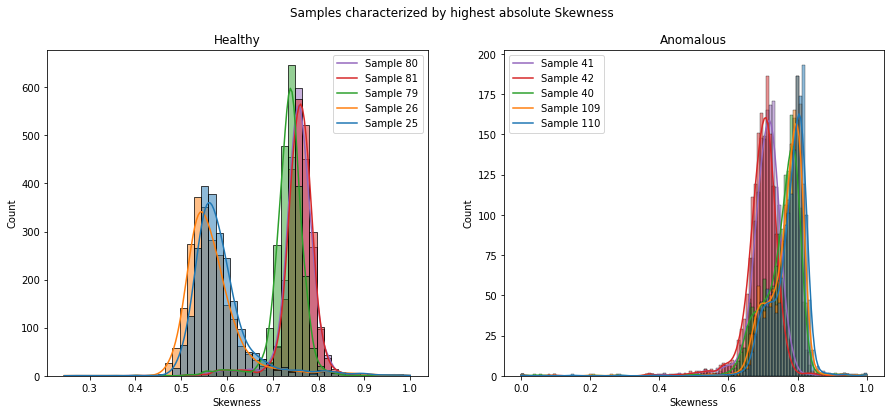

In [ ]:
histplot(X_skew, X_skew_anom, 'Skewness')

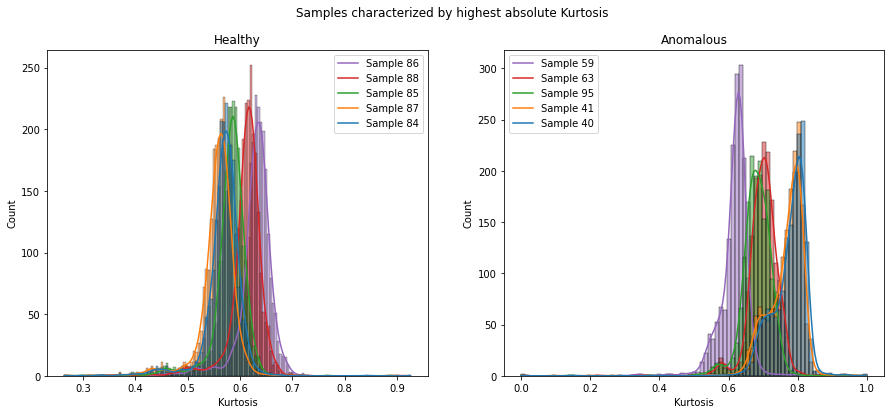

In [ ]:
histplot(X_kurt, X_kurt_anom, 'Kurtosis')

# Plot ECG

In [ ]:
def plot_ecg(x_norm, x_anom, title='', ylabel=''):
  plt.figure(figsize=(12, 8))
  plt.plot(x_norm, color='steelblue', label='Healthy')
  plt.plot(x_anom, color='maroon', label='Anomalous')
  plt.title(title)
  plt.xlabel('Samples [-]')
  plt.ylabel(ylabel)
  plt.grid()
  plt.legend(loc='upper right')
  plt.show()

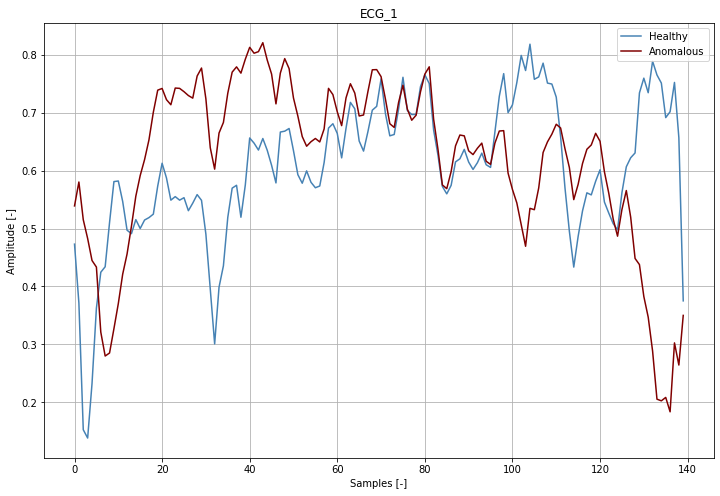

In [ ]:
plot_ecg(X_train_normal[0], X_train_anomalous[0], 'ECG_1', 'Amplitude [-]')

# FFT

In [ ]:
def adjust_fft(X):
  return np.column_stack([
    col.imag if any(np.iscomplex(col)) else col.real for col in fft(X).T
  ])

In [ ]:
X_train_normal_fft, X_train_anomalous_fft = map(lambda X: adjust_fft(X), [X_train_normal, X_train_anomalous])

X_train_normal_spectrum, X_train_anomalous_spectrum = map(
    lambda X: 20 * np.log10(np.abs(fft(X))), [X_train_normal, X_train_anomalous]
)

## Plot FFT

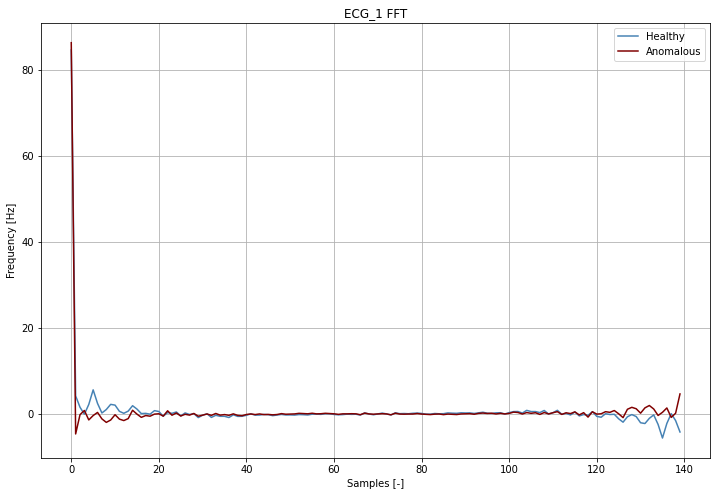

In [ ]:
plot_ecg(X_train_normal_fft[0], X_train_anomalous_fft[0], 'ECG_1 FFT', 'Frequency [Hz]')

## Plot Magnitude Spectrum in logarithmic scale

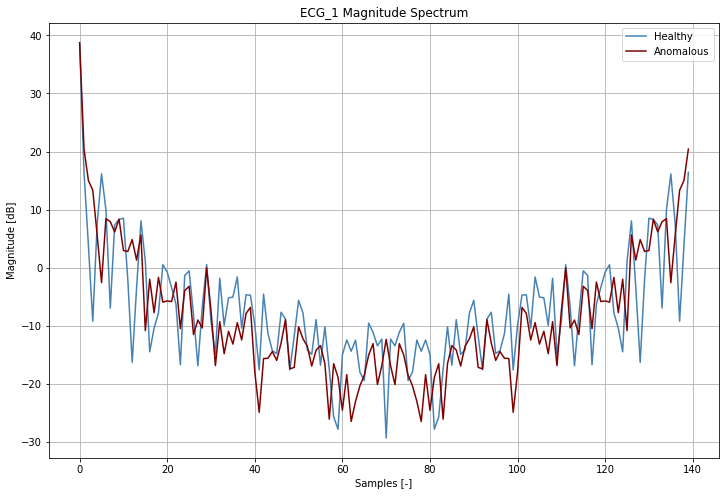

In [ ]:
plot_ecg(X_train_normal_spectrum[0], X_train_anomalous_spectrum[0], 'ECG_1 Magnitude Spectrum', 'Magnitude [dB]')

# Periodogram

In [ ]:
def plot_psd(x_norm, x_anom, title=''):
  (f, Pxx_norm), (_, Pxx_anom) = map(
      lambda x: periodogram(x, scaling='density', return_onesided=True), [x_norm, x_anom]
  )
  plt.figure(figsize=(12, 8))
  plt.semilogy(f, Pxx_norm, color='steelblue', label='Normal')
  plt.semilogy(f, Pxx_anom, color='maroon', label='Anomalous')
  plt.legend(loc='upper right')
  plt.title(title)
  plt.ylabel('PSD [V**2/Hz]')
  plt.xlabel('Frequency [Hz]')
  plt.grid()
  plt.show()

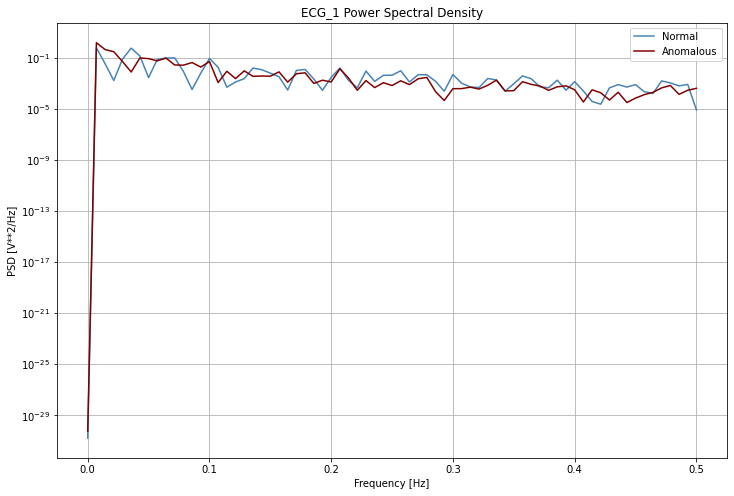

In [ ]:
plot_psd(X_train_normal[0], X_train_anomalous[0], title='ECG_1 Power Spectral Density')

# RMS

In [ ]:
def rms(X):
  return np.std(X - X.mean(), axis=0)

In [ ]:
def regression_line(x):
  xx = np.arange(x.shape[0])
  m, b = np.polyfit(xx, x, deg=1)
  return m * xx + b

In [ ]:
def plot_rms(X_normal, X_anom):
    plt.figure(figsize=(12, 6))
    labels = ['Healthy', 'Anomalous']
    colors = ['steelblue', 'maroon']
    data = [X_normal, X_anom]
    for i, X in enumerate(data):
      x_rms = rms(X)
      plt.plot(x_rms, label=labels[i], color=colors[i])
      line = regression_line(x_rms)
      plt.plot(line, color=colors[i], linewidth=2)
    plt.xlabel('Samples [-]')
    plt.ylabel('RMS [-]')
    plt.title('Root Mean Square with linear regression')
    plt.legend()
    plt.grid()
    plt.show()

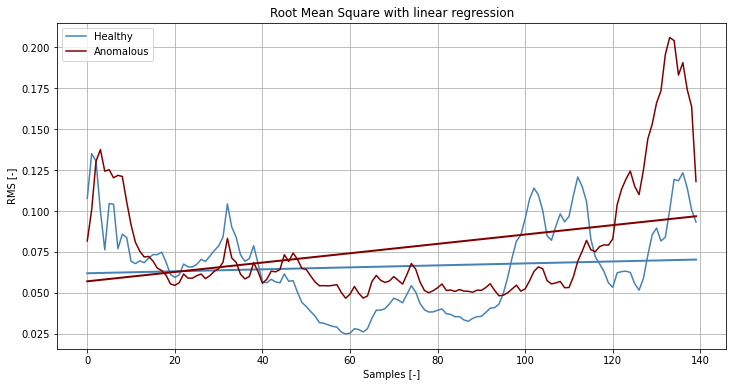

In [ ]:
plot_rms(X_train_normal, X_train_anomalous)

# Identify anomalies

In [ ]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.train_history = {}
    self.error_threshold = .0
    self.loss_threshold = .0
    self.encoder, self.decoder = self.autoencoder
  
  
  @property
  def autoencoder(self):
    encoder = Sequential([
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
    ])

    decoder = Sequential([
      Dense(32, activation='relu'),
      Dense(64, activation='relu'),
      Dense(140, activation='sigmoid')
    ])

    return encoder, decoder
  

  def call(self, X):
    encoded = self.encoder(X)
    decoded = self.decoder(encoded)
    return decoded
  
  
  def reconstruction_error(self, X):
    X_pred = self.call(X)
    return mean_absolute_error(X_pred, X)

  
  def reconstruction_loss(self, X):
    y_pred = self.predict(X)
    return mean_absolute_error(y_pred, X)

  
  def train(self, X_train, X_test, batch_size=32, lr=1e-3, verbosity=1):
    # Compile the model
    self.compile(optimizer=Adam(learning_rate=lr), loss='mae')

    # Stop learning as soon as validation loss remains unchanged for 5 epochs
    early_stopping = EarlyStopping(
        monitor ="val_loss",  
        mode ="min", 
        patience=5,  
        restore_best_weights=True,
        verbose=verbosity
    )

    # If no reducement of validation loss is present, learning rate is reduced
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        cooldown=5,
        verbose=verbosity
    )

    self.train_history = self.fit(
        X_train, X_train,
        validation_data=(X_test, X_test),
        batch_size=batch_size,
        epochs=100,
        shuffle=True,
        callbacks=[early_stopping, reduce_lr],
        verbose=verbosity
    ).history
    
    train_loss = self.reconstruction_loss(X_train)
    self.loss_threshold = np.mean(train_loss) + np.std(train_loss)

    train_error = self.reconstruction_error(X_train)
    self.error_threshold = np.mean(train_error) + 3 * np.std(train_error)
  
  
  def plot_reconstruction(self, x_true, x_pred, x_anom=[], title=""):
      labels = ['Input', 'Reconstruction', 'Error']
      xx = np.arange(x_pred.shape[0])
      plt.figure(figsize=(12, 8))
      plt.plot(x_true, 'steelblue', linewidth=2.5, label='Input', zorder=1)
      plt.plot(x_pred, 'darkorange', linewidth=2.5, label='Reconstruction', zorder=1)
      plt.fill_between(xx, x_true, x_pred, color='lightcoral', label='Error', alpha=0.75, zorder=0)
      if len(x_anom) == len(xx):
        n = x_anom.shape[0]
        n_anomalies = x_anom[~np.isnan(x_anom)].shape[0]
        labels.append(f'{n_anomalies}/{n} Anomalies')
        plt.scatter(xx, x_anom, color='red', marker='o', edgecolors='k', s=75, zorder=2)
      plt.legend(labels)
      plt.title(title if title else "ECG Reconstruction")
      plt.xlabel('Samples [-]')
      plt.ylabel('Amplitude [-]')
      plt.grid()
      plt.show()

  
  def plot_loss(self):
    plt.figure(figsize=(12, 8))
    plt.plot(self.train_history['loss'], color='steelblue', label='Training')
    plt.plot(self.train_history['val_loss'], color='maroon', label='Validation')
    plt.title("Autoencoder's Loss")
    plt.grid()
    plt.legend(loc='upper right')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylim([0, 0.1])
    plt.show()

  
  def plot_loss_distribution(self, X_train, X_test):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    colours = ['steelblue', 'maroon']
    labels = ['Training Data', 'Testing Data']
    for i, X in enumerate([X_train, X_test]):
      loss = self.reconstruction_loss(X)
      sns.histplot(
          loss, 
          ax=ax[i], 
          bins=20, 
          kde=True, 
          color=colours[i],
          label=labels[i]
      )
      ax[i].set_xlabel('Mean Absolute Error')
      ax[i].legend()

    plt.suptitle('Autoencoder Loss Distribution')
    plt.show()


  def anomalous_samples(self, X):
    # Get anomalous samples based on error between input and reconstruction
    encoded = pd.DataFrame(X)
    decoded = autoencoder.call(X)
    error = tf.math.abs(decoded - encoded)
    anomalies = encoded.mask(tf.math.less(error, self.error_threshold).numpy()).values
    return decoded, anomalies

  
  def anomalous_signals(self, X):
    # Get anomalous signals based on loss between normal and testing data
    anomalies = X[self.identify(X)]
    return anomalies

  
  def identify(self, X):
    # Identify whether signal is anomalous based on loss
    # - True (1): Normal signal
    # - False (0): Anomalous signal
    loss = self.reconstruction_loss(X)
    return tf.math.less(loss, self.loss_threshold).numpy()

  
  def describe(self, X_test, y_test):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score
    }
    for key in metrics:
      y_pred = self.identify(X_test)
      print(f'- {key}: {metrics[key](y_test, y_pred) * 100:.2f}%')

## Initialize Autoencoder

In [ ]:
autoencoder = Autoencoder()

## Train Autoencoder

In [ ]:
autoencoder.train(X_train_normal, X_test_scaled, batch_size=16, lr=1e-3, verbosity=0)

### Plot loss

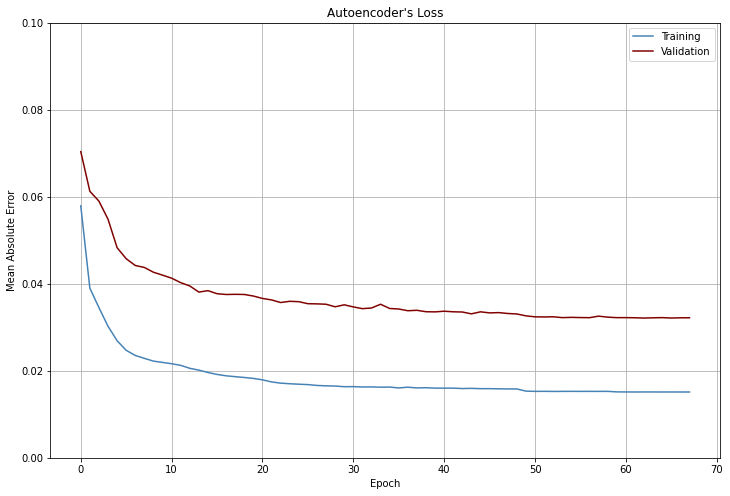

In [ ]:
autoencoder.plot_loss()

### Plot loss distribution

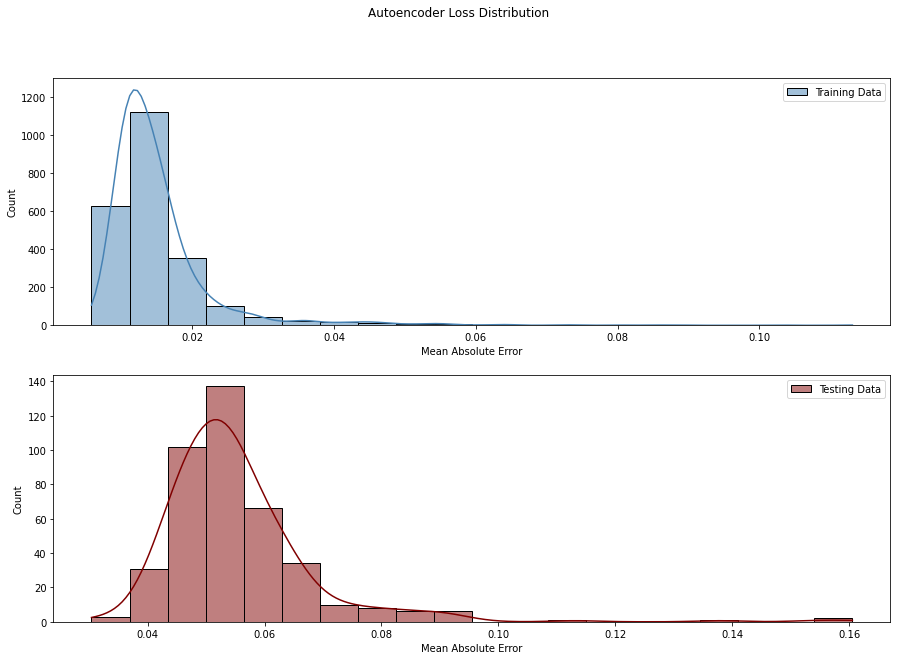

In [ ]:
autoencoder.plot_loss_distribution(X_train_normal, X_test_anomalous)

## Get anomalous samples

In [ ]:
decoded_train, anomalies_train = autoencoder.anomalous_samples(X_train_normal)

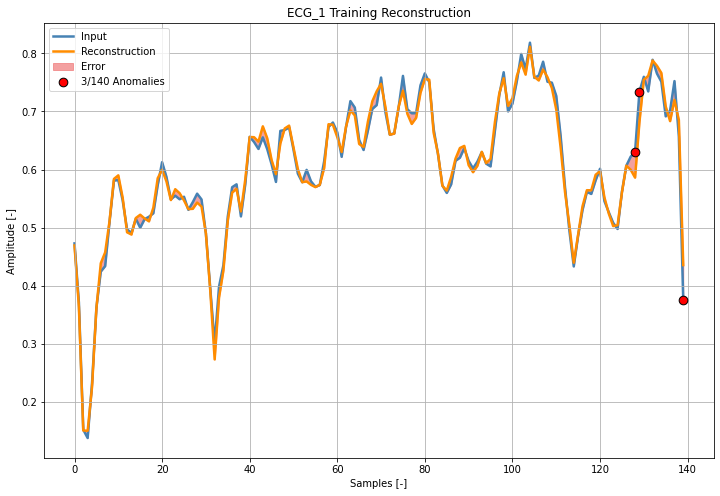

In [ ]:
autoencoder.plot_reconstruction(
    x_true=X_train_normal[0], 
    x_pred=decoded_train[0], 
    x_anom=anomalies_train[0],
    title='ECG_1 Training Reconstruction', 
)

In [ ]:
decoded_test, anomalies_test = autoencoder.anomalous_samples(X_test_scaled)

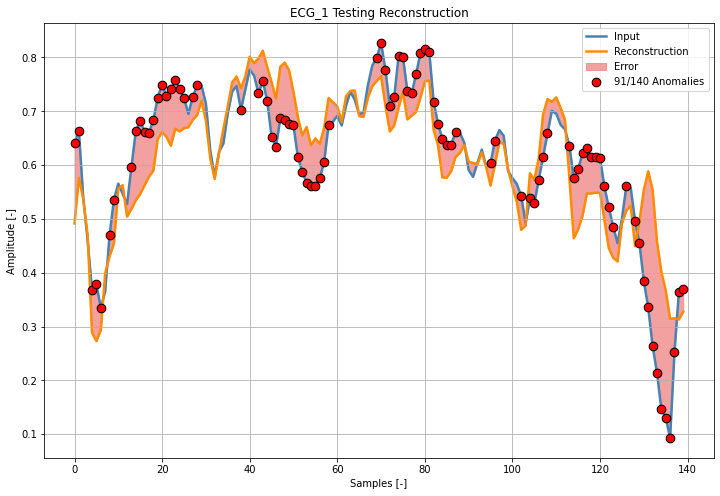

In [ ]:
autoencoder.plot_reconstruction(
    x_true=X_test_scaled[0], 
    x_pred=decoded_test[0], 
    x_anom=anomalies_test[0],
    title='ECG_1 Testing Reconstruction', 
)

## Validate autoencoder's metrics

In [ ]:
autoencoder.describe(X_test_scaled, y_test)

- Accuracy: 93.80%
- Precision: 100.00%
- Recall: 89.54%
